<a href="https://colab.research.google.com/github/tig1795/BBC_News_cluster/blob/main/Auto_Encoder_ganzer_Datensatz(Colab)_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing import sequence
import random
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import unicodedata
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Nadam
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import SGD, Adam
import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10230589411618999509
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 602428031376993258
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/news_POS_POS_tags_nouns_adjectives_verb.csv')

In [5]:
df.head(2)

,category,filename,title,content,number_of_tokens,number_of_types,stemmed_text,POS_tags,POS,nouns,adjectives,verb
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,415.0,244.0,quarterli profit at US media giant timewarn j...,"['_SP', 'NNP', 'NNS', 'IN', 'NNP', 'NNS', 'NN'...",high fourth own fourth underlying exceptional ...,74.0,22.0,1.0
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,379.0,230.0,the dollar ha hit it highest level against th...,"['_SP', 'DT', 'NN', 'VBZ', 'VBN', 'PRP$', 'JJS...",late recent sanguine current current next shar...,66.0,30.0,9.0


In [6]:
df.shape

(2225, 12)

In [7]:
df.content

0        Quarterly profits at US media giant TimeWarne...
1        The dollar has hit its highest level against ...
2        The owners of embattled Russian oil giant Yuk...
3        British Airways has blamed high fuel prices f...
4        Shares in UK drinks and food firm Allied Dome...
                              ...                        
2220     BT is introducing two initiatives to help bea...
2221     Computer users across the world continue to i...
2222     A new European directive could put software w...
2223     The man making sure US computer networks are ...
2224     Online role playing games are time-consuming,...
Name: content, Length: 2225, dtype: object

AutoEncoder mit ganzem Datensatz (Variante 1)

In [8]:
texts = df.content.to_list()

In [9]:
num_words = 1000
tk = Tokenizer(num_words=num_words, char_level=False, oov_token='UNK')

tk.fit_on_texts(texts)
sequences = tk.texts_to_sequences(texts)

char_dict = {char: index + 1 for index, char in enumerate(tk.word_index)}
char_dict[tk.oov_token] = max(char_dict.values()) + 1
tk.word_index = char_dict
n_letters = len(tk.word_index) + 1

In [10]:
maxlen = 1500

sequences = pad_sequences(sequences=sequences, maxlen=maxlen, padding='post')

In [11]:
X = []

for entry in sequences:
    oh_entry = []
    for token_index in entry:
        oh = np.zeros(num_words, dtype='int8')
        oh[token_index] = 1
        oh_entry.append(oh)
    X.append(oh_entry)
X = np.asarray(X, dtype='int8')

In [12]:
X.shape, X.nbytes * 1e6

((2225, 1500, 1000), 3337500000000000.0)

In [13]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [14]:
import keras 
#RMSprop(learning_rate=0.01)

recurrent_encoder = keras.models.Sequential([
    keras.layers.Embedding(num_words+1, 64, input_length=maxlen),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(maxlen, input_shape=[32]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation="softmax")),
    keras.layers.Flatten(),
    
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss='mse', optimizer=keras.optimizers.RMSprop(learning_rate=0.01),
                     metrics=[rounded_accuracy])
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32)                109504    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1500)              8353      
Total params: 117,857
Trainable params: 117,857
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = recurrent_ae.fit(sequences, sequences, epochs=10)

Epoch 1/10
70/70 [==============================] - 128s 2s/step - loss: 15845.0771 - rounded_accuracy: 0.0736
Epoch 2/10
70/70 [==============================] - 128s 2s/step - loss: 15845.0732 - rounded_accuracy: 0.0736
Epoch 3/10
70/70 [==============================] - 128s 2s/step - loss: 15845.0713 - rounded_accuracy: 0.0736
Epoch 4/10
70/70 [==============================] - 125s 2s/step - loss: 15845.0752 - rounded_accuracy: 0.0736
Epoch 5/10
70/70 [==============================] - 128s 2s/step - loss: 15845.0732 - rounded_accuracy: 0.0736
Epoch 6/10
70/70 [==============================] - 125s 2s/step - loss: 15845.0771 - rounded_accuracy: 0.0736
Epoch 7/10
70/70 [==============================] - 125s 2s/step - loss: 15845.0752 - rounded_accuracy: 0.0736
Epoch 8/10
70/70 [==============================] - 124s 2s/step - loss: 15845.0732 - rounded_accuracy: 0.0736
Epoch 9/10
70/70 [==============================] - 125s 2s/step - loss: 15845.0752 - rounded_accuracy: 0.0736
E

In [17]:
embeddings = recurrent_encoder.predict(sequences)
print(embeddings.shape)
with open('autoencoder_embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

(2225, 32)


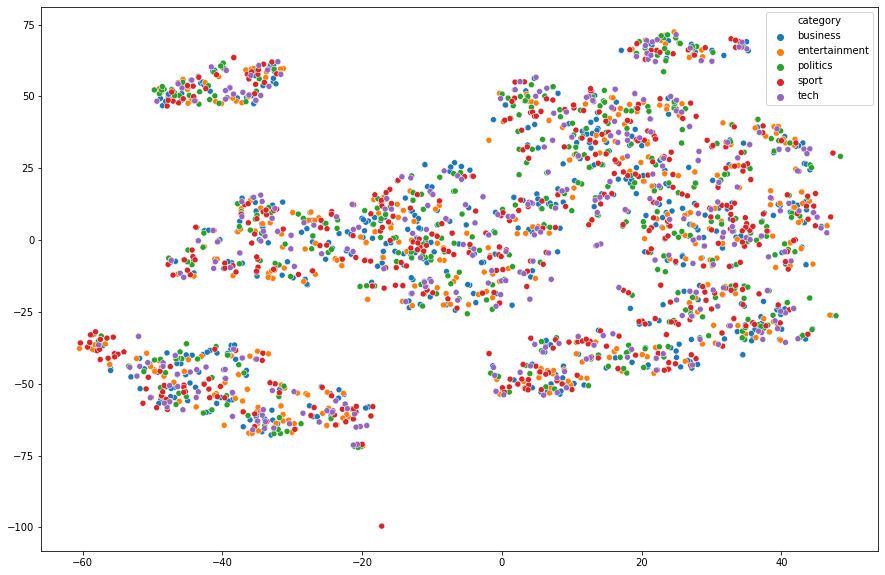

In [19]:
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

plt.figure(figsize=(15,10))
r = TSNE(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1], hue=df.category)

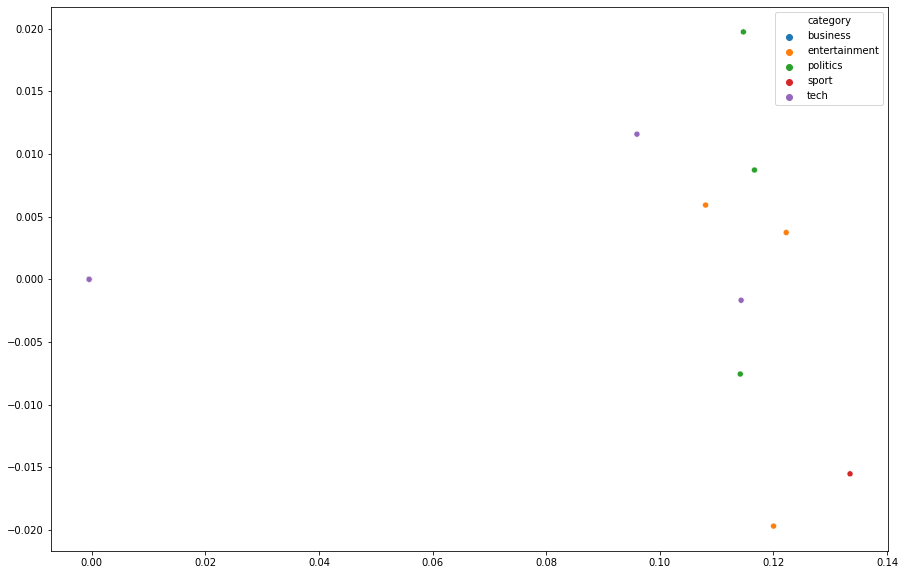

In [20]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

plt.figure(figsize=(15,10))
r = PCA(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1], hue=df.category)

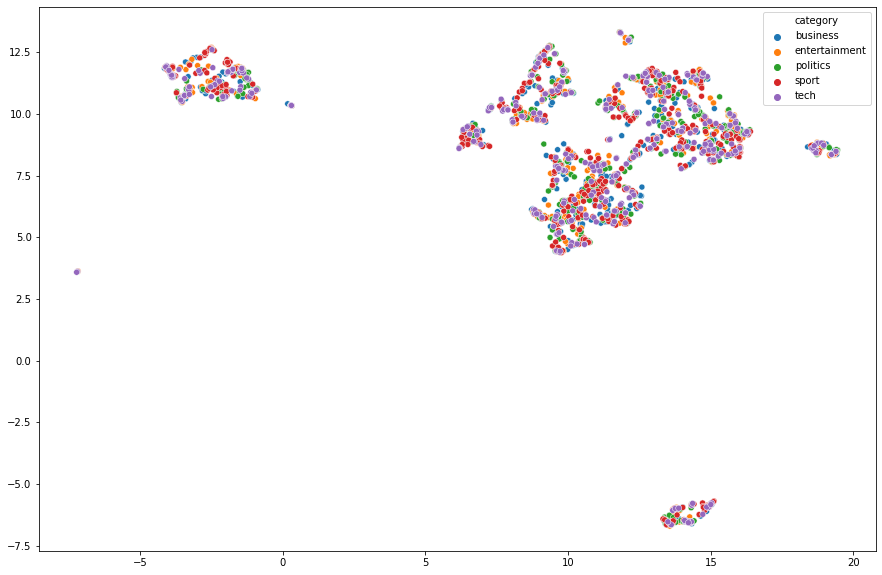

In [21]:
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

plt.figure(figsize=(15,10))
r = UMAP(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1], hue=df.category)

Variante 2 (Ganzer Datensatz)

In [23]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import pandas as pd
import unicodedata
import string
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Nadam
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import SGD, Adam

In [24]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14553829170814941838
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12219512077003925818
physical_device_desc: "device: XLA_CPU device"
]


In [25]:
df.content = df.content.str.replace('\s+', ' ')

In [26]:
df['text_length'] = df.content.apply(lambda x: len(x.split()))
daf = df[df['text_length'] >= 3000]

In [27]:
daf.text_length

762     3477
1185    4428
1275    3290
Name: text_length, dtype: int64

In [28]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters) +1 # for unknown token

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [29]:
texts = daf.content.apply(unicodeToAscii).to_list()

In [30]:
#Preprocessing(Keras)

num_words = 1000
tk = Tokenizer(num_words=num_words, char_level=False, oov_token='UNK')

tk.fit_on_texts(texts)
sequences = tk.texts_to_sequences(texts)

char_dict = {char: index + 1 for index, char in enumerate(tk.word_index)}
char_dict[tk.oov_token] = max(char_dict.values()) + 1
tk.word_index = char_dict
n_letters = len(tk.word_index) + 1



In [31]:
maxlen = 500

sequences = pad_sequences(sequences=sequences, maxlen=maxlen, padding='post')

In [32]:
X = []

for entry in sequences:
    oh_entry = []
    for token_index in entry:
        oh = np.zeros(num_words, dtype='int8')
        oh[token_index] = 1
        oh_entry.append(oh)
    X.append(oh_entry)
X = np.asarray(X, dtype='int8')

In [33]:
X.shape, X.nbytes * 1e6

((3, 500, 1000), 1500000000000.0)

In [34]:
def build_dense(num_words):
    
    stacked_encoder = Sequential([
        Input(shape=(num_words)),
        Dense(256, activation="linear"),
        Dense(128, activation="linear"),
    ])
    
    stacked_decoder = Sequential([
        Dense(128, activation='linear', input_shape=[128]),
        Dense(256, activation="linear"),
        Dense(num_words, activation="softmax")
    ])
    stacked_ae = Sequential([stacked_encoder, stacked_decoder])
    stacked_ae.compile(loss="mse",
    optimizer=RMSprop(learning_rate=0.01))
    return stacked_ae, stacked_encoder

In [35]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.models import Model

def build_recurrent_model(n_letters, maxlen):
    encoder = Sequential([
        Input(shape=(maxlen,)),
        Embedding(n_letters, 32),
        LSTM(32,
             return_sequences=True,
            ),
        LSTM(16,
             return_sequences=False,
            ),
    ])
    decoder = Sequential([
        RepeatVector(maxlen),
        LSTM(16,
             return_sequences=True,
            ),
        TimeDistributed(Dense(n_letters, activation='softmax'))
    ])
    autoencoder = Sequential([encoder, decoder])
    autoencoder.compile(loss='mse', optimizer='rmsprop')
    return autoencoder, encoder

In [36]:
callbacks = [
    ModelCheckpoint(filepath='../Results/autoencoder/model.{epoch:02d}-{loss:.2f}.h5',
                    monitor='loss',
                    save_best_only=True,
                    save_freq=5),
    TensorBoard(log_dir='../Results/tensorboard_logs',
                embeddings_freq=1)
]

In [37]:
recurrent_autoencoder, recurrent_encoder = build_recurrent_model(num_words, maxlen)
recurrent_autoencoder.summary()
recurrent_encoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 16)                43456     
_________________________________________________________________
sequential_4 (Sequential)    (None, 500, 1000)         19112     
Total params: 62,568
Trainable params: 62,568
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           32000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 32)           8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                3136      
Total params: 43,456
Trainab

In [38]:
history = recurrent_autoencoder.fit(sequences, X, batch_size=64, epochs=10, callbacks=callbacks)

Epoch 1/10
1/1 [==============================] - 0s 27ms/step - loss: 9.9900e-04
Epoch 2/10
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 22ms/step - loss: 9.9900e-04
Epoch 3/10
1/1 [==============================] - 0s 17ms/step - loss: 9.9900e-04
Epoch 4/10
1/1 [==============================] - 0s 17ms/step - loss: 9.9900e-04
Epoch 5/10
1/1 [==============================] - 0s 17ms/step - loss: 9.9900e-04
Epoch 6/10
1/1 [==============================] - 0s 16ms/step - loss: 9.9900e-04
Epoch 7/10
1/1 [==============================] - 0s 16ms/step - loss: 9.9900e-04
Epoch 8/10
1/1 [==============================] - 0s 17ms/step - loss: 9.9900e-04
Epoch 9/10
1/1 [==============================] - 0s 17ms/step - loss: 9.9900e-04
Epoch 10/10
1/1 [==============================] - 0s 17ms/step - loss: 9.9900e-04


In [39]:
print(embeddings.shape)
with open('autoencoder_embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

(2225, 32)


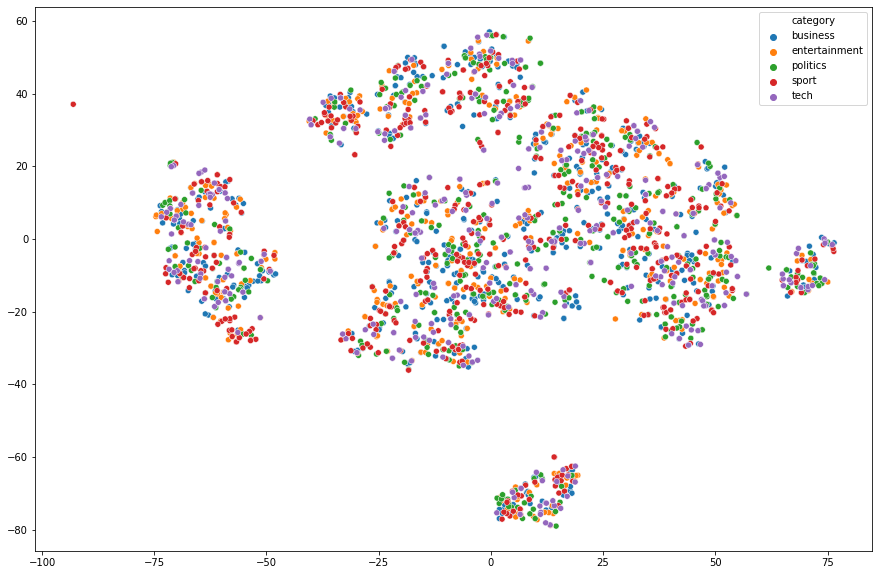

In [40]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

#plt.figure(figsize=(30,20))
#r = UMAP(n_components=2).fit_transform(embeddings)
#sns.scatterplot(x=r[:,0], y=r[:,1], hue=df.Genre1)

plt.figure(figsize=(15, 10))
r = TSNE(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1], hue=df.category)

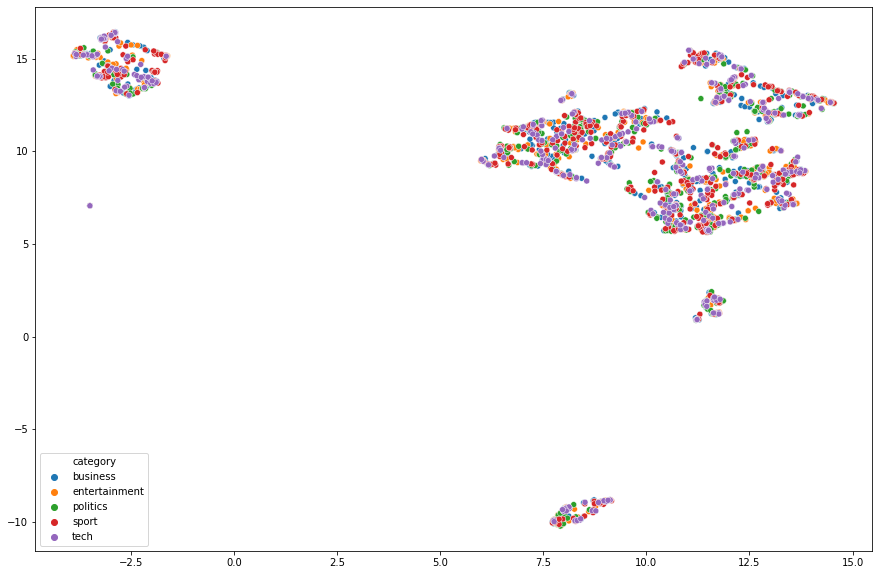

In [43]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

plt.figure(figsize=(15,10))
r = UMAP(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1], hue=df.category)

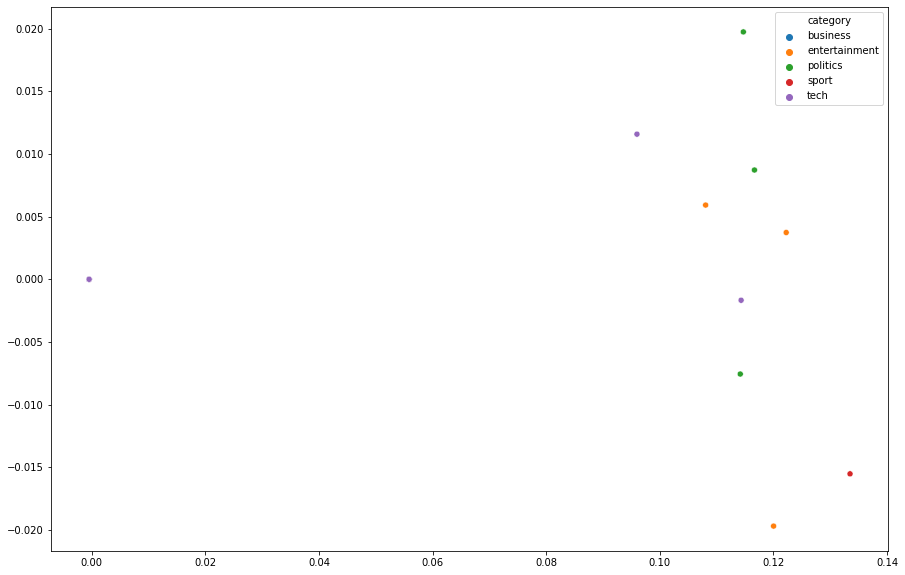

In [44]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

plt.figure(figsize=(15, 10))
r = PCA(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1], hue=df.category)